In [156]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from itertools import combinations
from matplotlib import cm
from matplotlib.colors import ListedColormap
plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import KFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from scipy import sparse
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_score
import xgboost as xgb
from sklearn.model_selection import KFold,TimeSeriesSplit
from sklearn.model_selection import StratifiedKFold
from joblib import dump, load
import scikitplot as skplt
from sklearn import preprocessing
from matplotlib.colors import ListedColormap
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from scipy.stats import spearmanr
import lightgbm as lgb

In [3]:
'''https://www.mikulskibartosz.name/how-to-reduce-memory-usage-in-pandas/
function found here'''


def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(
                        np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(
                        np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(
                        np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(
                        np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(
                        np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(
                        np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) /
                                        start_mem))

    return df

## Loading and Cleaning the data

Data can be found - https://www.kaggle.com/c/ieee-fraud-detection/overview

In [4]:
path='ieee-fraud-detection/train_identity.csv'

In [5]:
train_identity = pd.read_csv('ieee-fraud-detection/train_identity.csv')
train_transaction = pd.read_csv('ieee-fraud-detection/train_transaction.csv')
train = pd.merge(train_transaction,
                 train_identity,
                 on='TransactionID',
                 how='left')

In [253]:
test.shape

(506691, 433)

In [8]:
train.shape

(590540, 434)

In [9]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [12]:
#we dont need the individual train transaction and train identity anymore 
del train_transaction, train_identity

First we need to create a strategy to remove the NA values from the data

In [13]:
def NA_value_sum(df):
    all_data_na=df.isna().sum()/len(df)*100
    all_data_na=all_data_na.drop(all_data_na[all_data_na==0].index).sort_values(ascending=False)
    return all_data_na

In [14]:
#getting list of columns with missing values
missing_values=NA_value_sum(train)


In [17]:
#getting columns with over 90% missing values
na_high=missing_values[missing_values>90]

In [18]:
#finding the columns which have almost all the same value eg 99% of the values are 1.0
high_single_val = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.95 and col !='isFraud']

In [19]:
#dropping columns with over 90 % na or with over 95% of the values being the same
drop_cols=list(set(list(na_high.index)+high_single_val))

In [20]:
for col in drop_cols:
    try:
        train.drop(columns=[col],inplace=True)
    except:
        print(col)

In [21]:
missing_values_ref=NA_value_sum(train)

In [24]:
#going to turn the na values into missing for categorical columns
for col in train.select_dtypes(include=['object']).columns:
    train[col].fillna(value='missing',inplace=True)

In [25]:
#for the time deltas id imagine that if there is a nan it means that it is the first time the account has a transaction
for val in range(1, 16):
    try:
        train[f'D{val}'].fillna(-1, inplace=True)
    except:
        print(val)

7


In [258]:
missing_values_ref=NA_value_sum(train)
missing_values_ref[:10]

Series([], dtype: float64)

Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.
“For example, how many times the payment card associated with a IP and email or address appeared in 24 hours time range, etc.”
"All Vesta features were derived as numerical. some of them are count of orders within a clustering, a time-period or condition,
so the value is finite and has ordering (or ranking). I wouldn't recommend to treat any of them as categorical. If any of them resulted in binary by chance, it maybe worth trying."

Above from the discussion boards

In [35]:
v_cols=[col for col  in train.columns if 'V' in col]
for col in v_cols:
    train[col].fillna(-1,inplace=True)

“id01 to id11 are numerical features for identity, which is collected by Vesta and security partners such as device rating, ip_domain rating, proxy rating, etc. Also it recorded behavioral fingerprint like account login times/failed to login times, how long an account stayed on the page, etc. All of these are not able to elaborate due to security partner T&C. I hope you could get basic meaning of these features, and by mentioning them as numerical/categorical, you won't deal with them inappropriately.”

In [36]:
id_cols=[col for col in train.columns if 'id' in col or 'dist1' in col]
for col in id_cols:
    train[col].fillna(-1,inplace=True)

In [37]:
train.dropna(inplace=True)

In [38]:
missing_values_ref=NA_value_sum(train)
missing_values_ref

Series([], dtype: float64)

In [39]:
#found on the discussion page - thought i was going to have to write it out
#P_ and (R__) emaildomain: purchaser and recipient email domain

emails = {
    'gmail': 'google',
    'att.net': 'att',
    'twc.com': 'spectrum',
    'scranton.edu': 'other',
    'optonline.net': 'other',
    'hotmail.co.uk': 'microsoft',
    'comcast.net': 'other',
    'yahoo.com.mx': 'yahoo',
    'yahoo.fr': 'yahoo',
    'yahoo.es': 'yahoo',
    'charter.net': 'spectrum',
    'live.com': 'microsoft',
    'aim.com': 'aol',
    'hotmail.de': 'microsoft',
    'centurylink.net': 'centurylink',
    'gmail.com': 'google',
    'me.com': 'apple',
    'earthlink.net': 'other',
    'gmx.de': 'other',
    'web.de': 'other',
    'cfl.rr.com': 'other',
    'hotmail.com': 'microsoft',
    'protonmail.com': 'other',
    'hotmail.fr': 'microsoft',
    'windstream.net': 'other',
    'outlook.es': 'microsoft',
    'yahoo.co.jp': 'yahoo',
    'yahoo.de': 'yahoo',
    'servicios-ta.com': 'other',
    'netzero.net': 'other',
    'suddenlink.net': 'other',
    'roadrunner.com': 'other',
    'sc.rr.com': 'other',
    'live.fr': 'microsoft',
    'verizon.net': 'yahoo',
    'msn.com': 'microsoft',
    'q.com': 'centurylink',
    'prodigy.net.mx': 'att',
    'frontier.com': 'yahoo',
    'anonymous.com': 'other',
    'rocketmail.com': 'yahoo',
    'sbcglobal.net': 'att',
    'frontiernet.net': 'yahoo',
    'ymail.com': 'yahoo',
    'outlook.com': 'microsoft',
    'mail.com': 'other',
    'bellsouth.net': 'other',
    'embarqmail.com': 'centurylink',
    'cableone.net': 'other',
    'hotmail.es': 'microsoft',
    'mac.com': 'apple',
    'yahoo.co.uk': 'yahoo',
    'netzero.com': 'other',
    'yahoo.com': 'yahoo',
    'live.com.mx': 'microsoft',
    'ptd.net': 'other',
    'cox.net': 'other',
    'aol.com': 'aol',
    'juno.com': 'other',
    'icloud.com': 'apple',
    'missing':'missing'
}

In [40]:
train['P_email_provider']=train['P_emaildomain'].map(emails)
train['R_email_provider']=train['P_emaildomain'].map(emails)

In [41]:
train['P_email_provider'].value_counts()

google         197690
yahoo          104304
missing         90415
other           46122
microsoft       31901
aol             28098
apple            7567
att              6881
spectrum         1036
centurylink       641
Name: P_email_provider, dtype: int64

In [34]:
#some values will be missing as some transactions dont need a recipient email
train['R_email_provider'].value_counts()

google         197690
yahoo          104304
missing         90415
other           46122
microsoft       31901
aol             28098
apple            7567
att              6881
spectrum         1036
centurylink       641
Name: R_email_provider, dtype: int64

Because we do not know what most of the columns mean exactly I have taken quite a few of the variables and created some new features out of their interactions.

In [243]:
train['productcd_transamt_mean'] = train['TransactionAmt'] / train.groupby(
    ['ProductCD'])['TransactionAmt'].transform('mean')

train['productcd_transamt_std'] = train['TransactionAmt'] / train.groupby(
    ['ProductCD'])['TransactionAmt'].transform('std')

train['TransactionAmt_Log'] = np.log(train['TransactionAmt'])

In [45]:
col_1 = ['id_02', 'D15', 'TransactionAmt']
col_2 = ['card4', 'card1', 'addr1']

for column_1 in col_1:
    for column_2 in col_2:
        train[f'{column_1}_mean_{column_2}'] = train[column_1] /train.groupby(
            [column_2])[column_1].transform('mean')
        train[f'{column_1}_std_{column_2}'] = train[column_1] / train.groupby(
            [column_2])[column_1].transform('std')

In [46]:
a= ['card1','id_02','addr2','TransactionAmt','ProductCD']
b=list(combinations(a,2))
b=b[:-1]

In [47]:
for tup in b:
    train[f'{tup[0]}_{tup[1]}_mean'] = train[tup[0]] / train.groupby(
        [tup[1]])[tup[0]].transform('mean')

    train[f'{tup[0]}_{tup[1]}_std'] = train[tup[0]] / train.groupby(
        [tup[1]])[tup[0]].transform('std')

In [48]:
missing_values_ref=NA_value_sum(train)
missing_values_ref

card1_id_02_std             10.872332
addr2_TransactionAmt_std     1.777307
id_02_TransactionAmt_std     1.777307
card1_TransactionAmt_std     1.777307
D15_std_card1                0.760509
TransactionAmt_std_card1     0.558432
id_02_std_card1              0.558432
D15_mean_card1               0.420282
D15_std_addr1                0.050131
D15_mean_addr1               0.048771
TransactionAmt_std_addr1     0.023900
id_02_std_addr1              0.023900
id_02_addr2_std              0.003303
card1_addr2_std              0.003303
dtype: float64

In [49]:
train.drop(columns=['card1_id_02_std','id_02_ProductCD_std'],inplace=True)

In [50]:
train.dropna(inplace=True)

In [51]:
missing_values_ref=NA_value_sum(train)
missing_values_ref

Series([], dtype: float64)

In [52]:
train_cont=train.select_dtypes(include=['number'])

In [53]:
inf_cols=train_cont.columns.to_series()[np.isinf(train_cont).any()]

In [54]:
#getting rid of columns where most of the values are infinite
for col in list(inf_cols):
    print(col)
    print(train[col].value_counts().index[0])
    print(train[col].value_counts().iloc[0])
    print('-'*10)
    if train[col].value_counts().index[0] == np.inf or train[col].value_counts(
    ).index[0] == -np.inf:
        if train[col].value_counts().iloc[0]>5000:
            try:
                train.drop(columns=[col],inplace=True)
            except:
                print('no')
        

id_02_std_card1
-inf
38102
----------
id_02_std_addr1
-1.8609154772769163e-05
36594
----------
D15_mean_card1
0.0
116469
----------
D15_std_card1
0.0
116469
----------
D15_mean_addr1
0.0
116469
----------
D15_std_addr1
0.0
116469
----------
TransactionAmt_std_card1
0.5048049786045314
1466
----------
TransactionAmt_std_addr1
0.23764400835503752
3417
----------
card1_addr2_std
1.6239413309348043
14781
----------
card1_TransactionAmt_std
inf
2808
----------
id_02_addr2_std
-1.6388585083115748e-05
422171
----------
id_02_TransactionAmt_std
-inf
277449
----------
addr2_TransactionAmt_std
inf
236039
----------


In [55]:
#then dropping the values if there isnt that many
train.replace([np.inf, -np.inf], np.nan,inplace=True)
train.dropna(inplace=True)

In [56]:
train_cont=train.select_dtypes(include=['number'])
train_cont.columns.to_series()[np.isinf(train_cont).any()]

Series([], dtype: object)

In [57]:
missing_values_ref=NA_value_sum(train)
missing_values_ref

Series([], dtype: float64)

From the discussion boards it seems as though we have been given a year and one month period.

In [58]:
train['trans_hour'] = np.floor(train['TransactionDT'] / 3600) % 24
train['trans_day_of_week'] = np.floor((train['TransactionDT'] / (3600 * 24) - 1) % 7)


In [136]:
#goin to do some count occurences was reading the winner of the santander competition and was wondering if the makers of this dataset have done the same thing
card_cols.append('card4')
card_cols.append('card6')

In [143]:
for col in card_cols:
    train[f'{col}_count']=train.card1.map(train.card1.value_counts(dropna=False))

In [140]:

trainq['q']=train.card1.map(train.card1.value_counts())

## EDA

In [59]:
X=train.copy()
y=X.pop('isFraud')

In [60]:
X=reduce_mem_usage(X)

Memory usage of dataframe is 1611.74 MB
Memory usage after optimization is: 434.53 MB
Decreased by 73.0%


In [63]:
X_cont=X.select_dtypes(include=['number'])

In [64]:
X_cont.shape

(493584, 396)

https://towardsdatascience.com/having-an-imbalanced-dataset-here-is-how-you-can-solve-it-1640568947eb

Reading the above article has illuminated how correlation between variables may be concealed due to the imbalanced nature of the dataset. Therefore it may be wise to resample before looking at correlation between variables. To do this I am going to use both Near Miss and SMOTE and if there are any differences and if so what differences there are. 

In [65]:
nm = NearMiss()
X_res, y_res = nm.fit_resample(X_cont, y)

In [66]:
sm = SMOTE(random_state=1)
X_ove, y_ove = sm.fit_resample(X_cont, y)

In [67]:
oversampled = pd.DataFrame(X_ove, columns=X_cont.columns)
oversampled['isFraud'] = y_ove
undersampled = pd.DataFrame(X_res, columns=X_cont.columns)
undersampled['isFraud'] = y_res

In [68]:
oversampled_corr_table=oversampled.corr()

In [69]:
corr_table=train.corr()

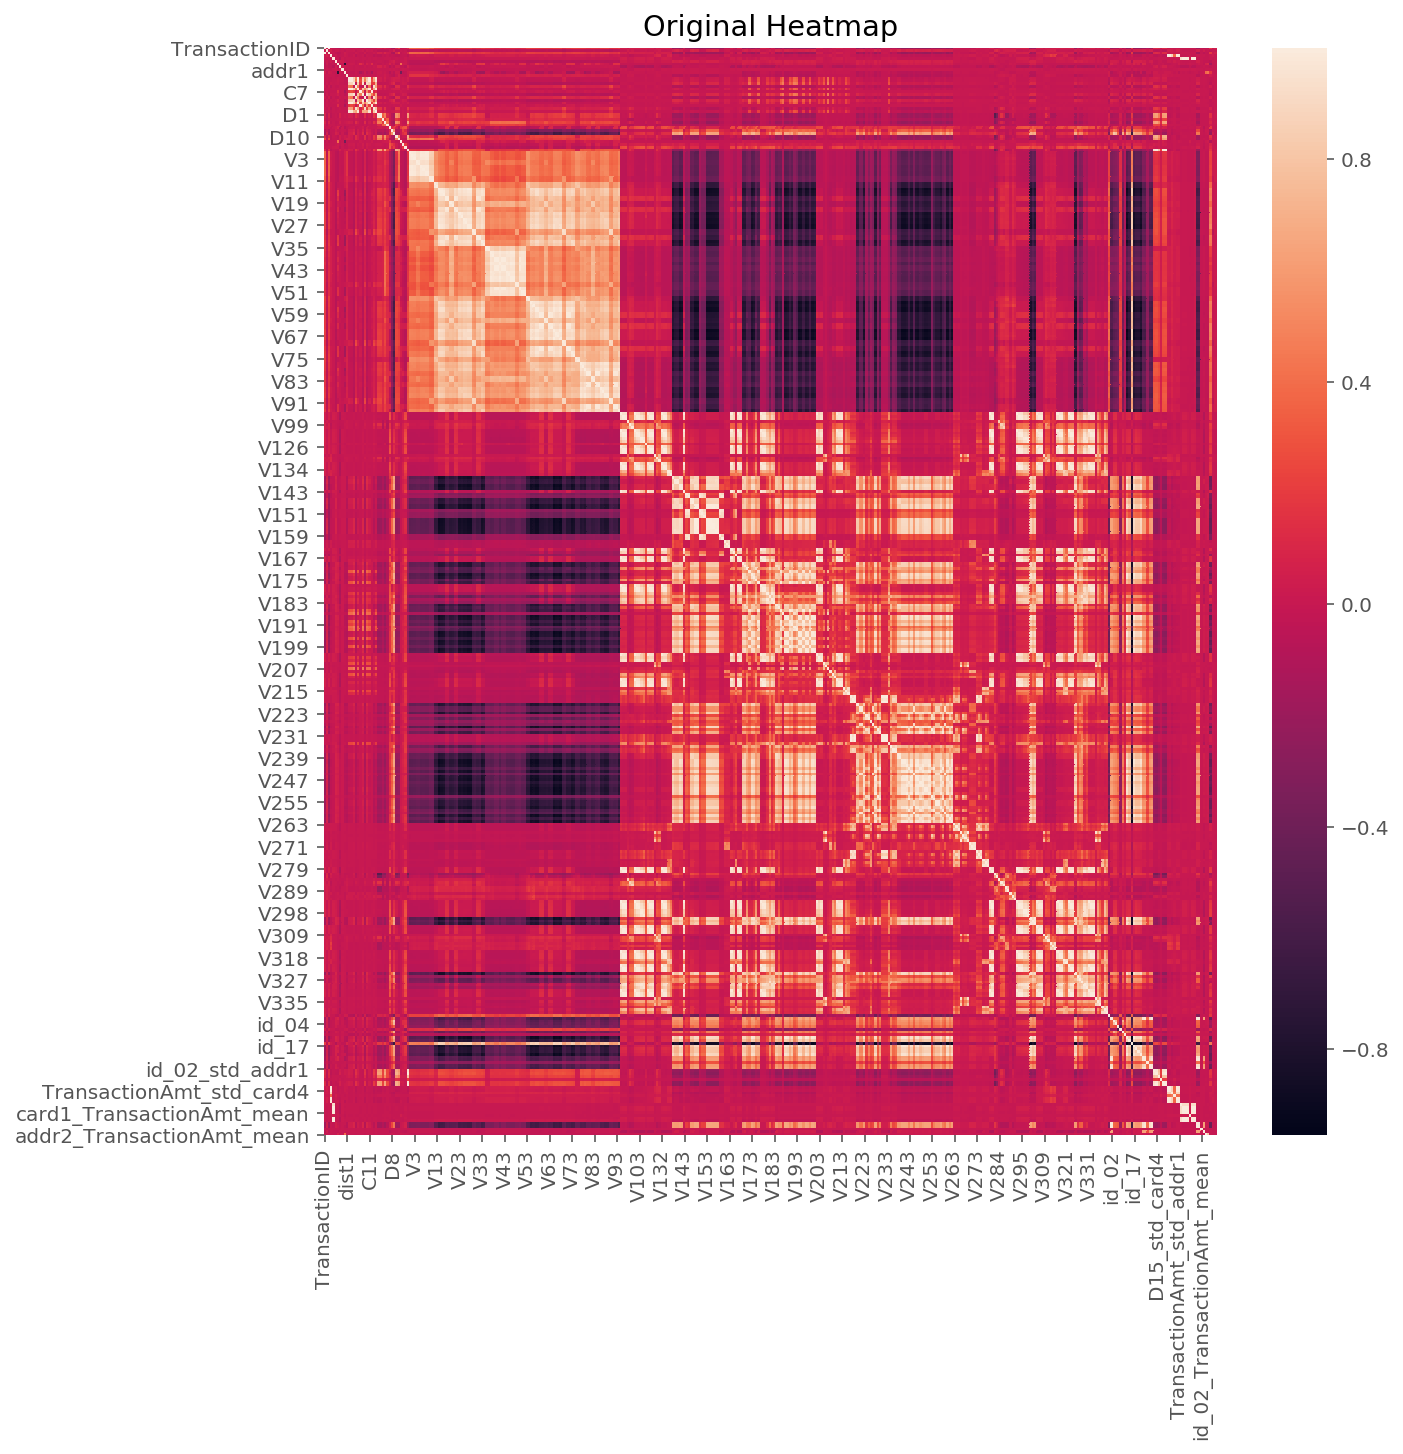

In [250]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.title.set_text('Original Heatmap')
sns.heatmap(corr_table);

There seems to be a lot of areas with high correlation which makes sense as we just created quite a few new features based on other features. This makes it seem like PCA would be a good avenue to explore especially as there is so many columns for performance sake it may make sense.

In [71]:
def create_corr_single(corr, variable):
    c = corr.copy()
    c_var = c[[variable]]
    c_var['abs'] = c_var[variable].map(lambda x: abs(x))
    return c_var

In [72]:
orig_corr = create_corr_single(corr_table, 'isFraud')
orig_corr[['abs']].sort_values(by='abs', ascending=False)[:10]

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,abs
isFraud,1.000000
V283,0.133057
V147,0.114214
V282,0.113296
V158,0.103699
V239,0.103202
V140,0.102503
V201,0.101039
V156,0.100952
V146,0.098937


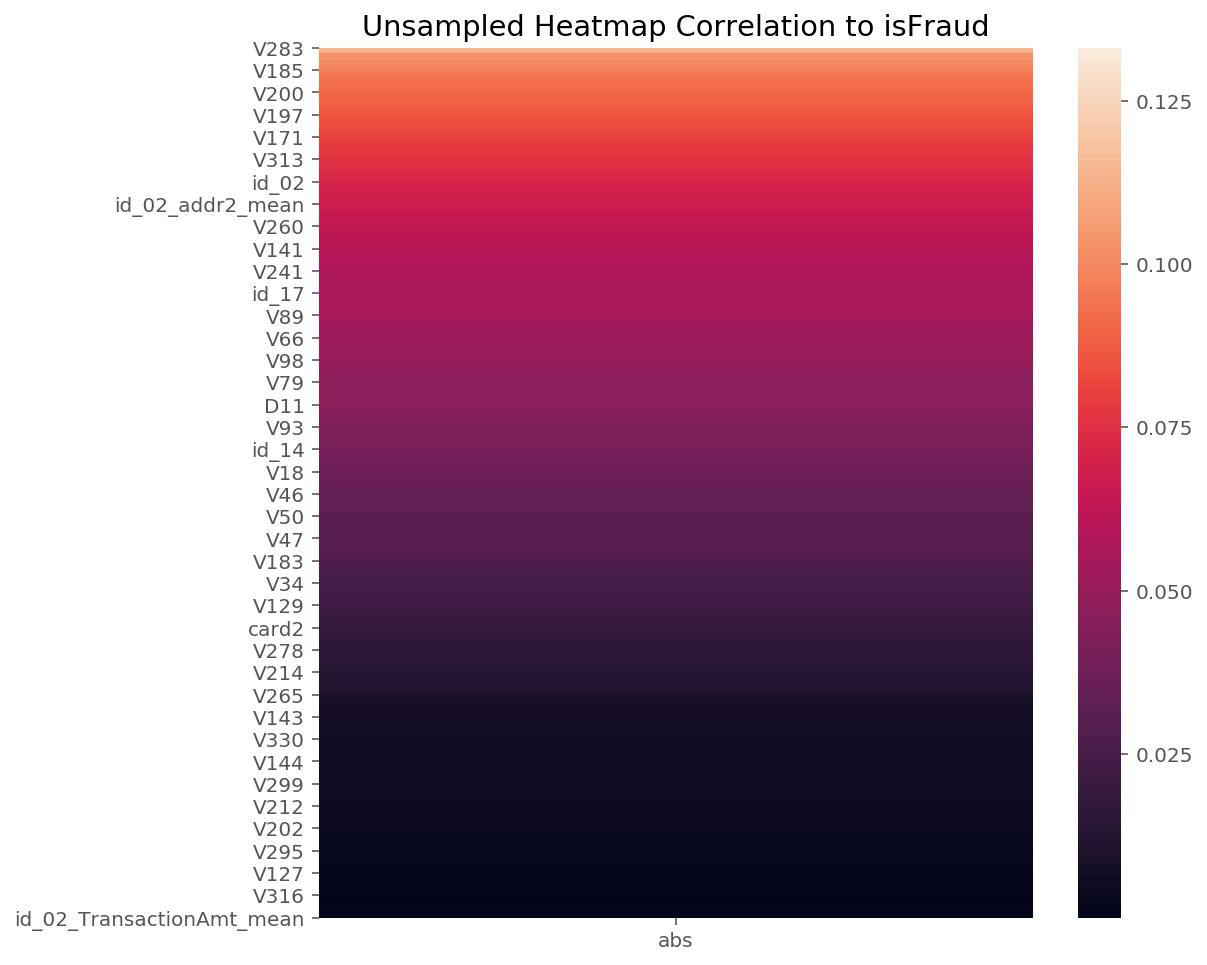

In [249]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.title.set_text('Unsampled Heatmap Correlation to isFraud')
sns.heatmap(orig_corr[['abs']].sort_values(by='abs', ascending=False)[1:]);

In [74]:
oversample_corr_table_fraud = oversampled_corr_table.copy()
oversample_corr_table_fraud = oversample_corr_table_fraud[['isFraud']]
oversample_corr_table_fraud['abs'] = oversample_corr_table_fraud.isFraud.map(
    lambda x: abs(x))

In [75]:
oversample_corr_table_fraud.sort_values(by='abs', ascending=False)[1:10]

,isFraud,abs
V29,-0.289530,0.289530
V69,-0.289410,0.289410
V70,-0.286736,0.286736
V30,-0.283881,0.283881
V90,-0.282045,0.282045
V91,-0.278831,0.278831
V282,0.278493,0.278493
V283,0.264957,0.264957
V48,-0.233391,0.233391


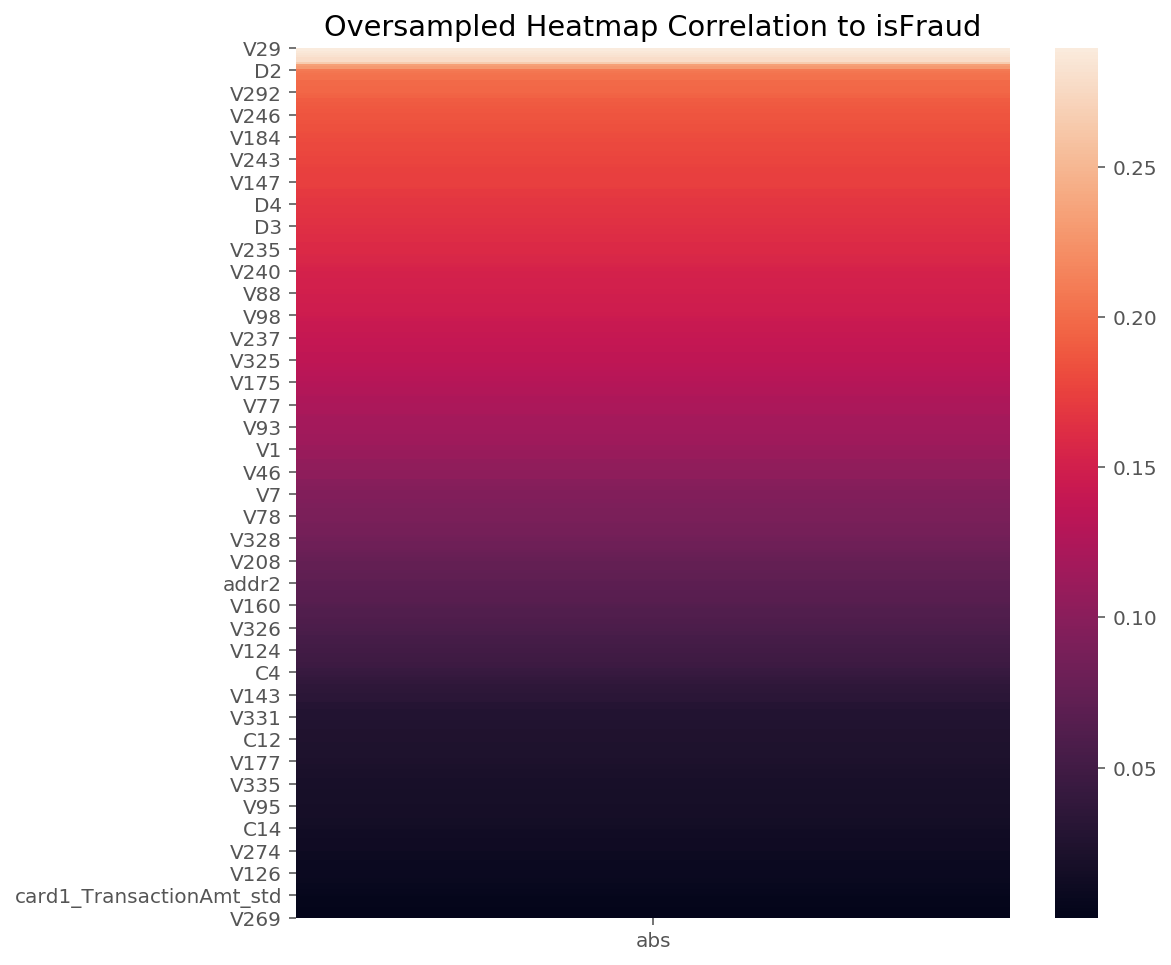

In [248]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.title.set_text('Oversampled Heatmap Correlation to isFraud')
sns.heatmap(oversample_corr_table_fraud[['abs'
                                         ]].sort_values(by='abs',
                                                        ascending=False)[1:]);

In [77]:
undersampled_corr_table = undersampled.corr()

In [78]:
undersampled_corr = create_corr_single(undersampled_corr_table, 'isFraud')
undersampled_corr[['abs']].sort_values(by='abs', ascending=False)[:10]

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,abs
isFraud,1.000000
V69,0.436020
V29,0.432641
V70,0.426695
V30,0.420984
id_11,0.400540
V240,0.394001
V241,0.394001
V173,0.393889
id_17,0.392827


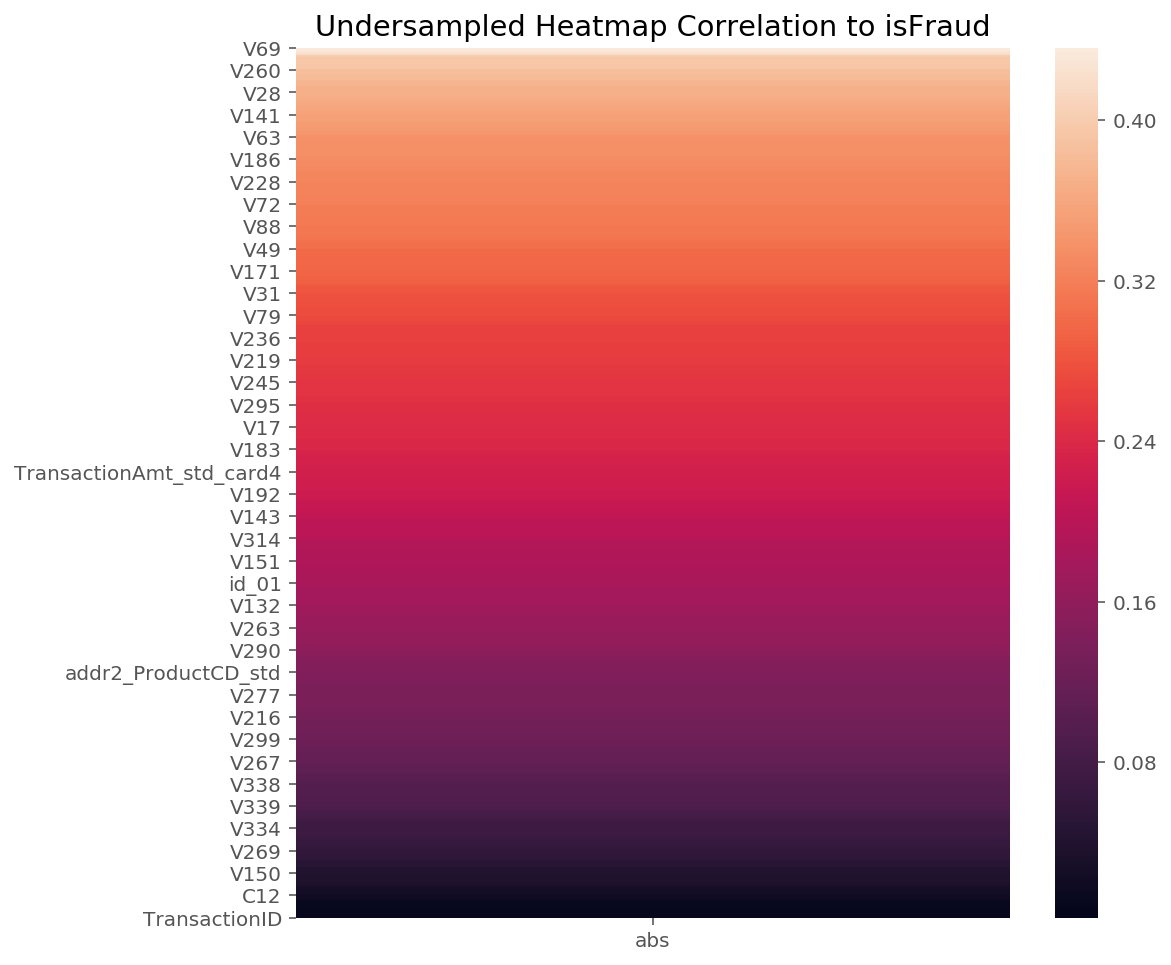

In [247]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.title.set_text('Undersampled Heatmap Correlation to isFraud')
sns.heatmap(undersampled_corr[['abs']].sort_values(by='abs',
                                                   ascending=False)[1:]);

It is of note that both the correlation strengths changes depending on over sampling or under sampling and also what are the most correlated factors changes slightly as well.

In [80]:
spearmanr(oversample_corr_table_fraud['abs'].sort_values(ascending=False)[:30],
          undersampled_corr['abs'].sort_values(ascending=False)[:30])

SpearmanrResult(correlation=0.9997775058377179, pvalue=1.781470474311808e-48)

In [94]:
y.value_counts()

0    481601
1     11983
Name: isFraud, dtype: int64

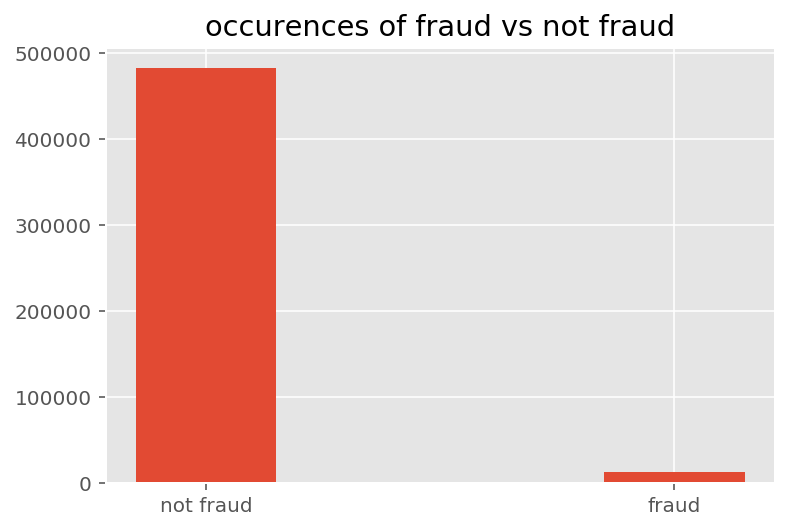

In [96]:

plt.bar(x=['not fraud','fraud'],height=y.value_counts(),width=0.3)
plt.title('occurences of fraud vs not fraud');

Can see there is a massive disparity between the amount of fraudulent transactions and the amount of non fraudulent transactions.

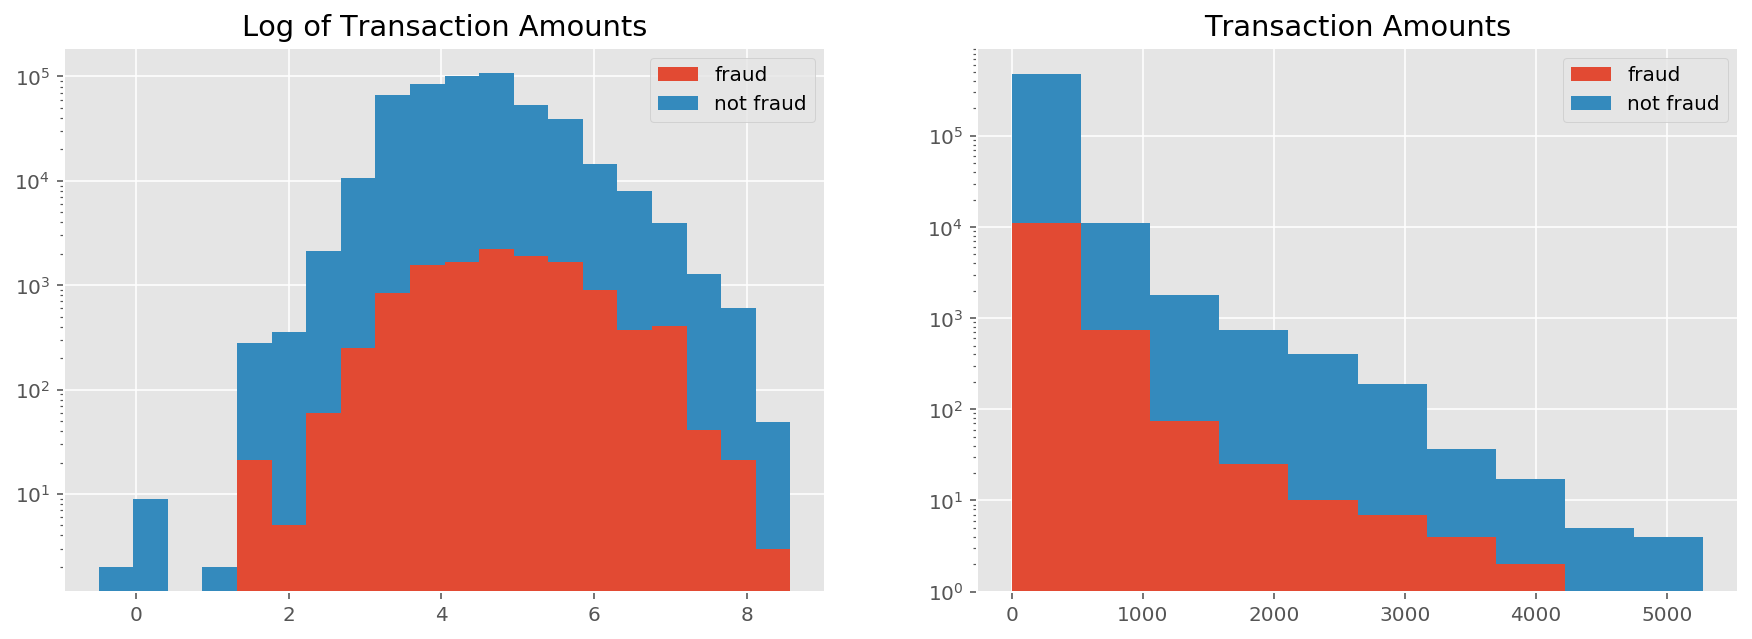

In [245]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].hist([
    train[train.isFraud == 1]['TransactionAmt_Log'],
    train[train.isFraud == 0]['TransactionAmt_Log']
],
           stacked=True,
           bins=20,
           log=True)
ax[0].title.set_text('Log of Transaction Amounts')
ax[0].legend(labels=['fraud', 'not fraud'], loc='upper right')

ax[1].hist([
    train[train.isFraud == 1]['TransactionAmt'],
    train[train.isFraud == 0]['TransactionAmt']
],
           stacked=True,
           log=True)
ax[1].title.set_text('Transaction Amounts')
ax[1].legend(labels=['fraud', 'not fraud'], loc='upper right');

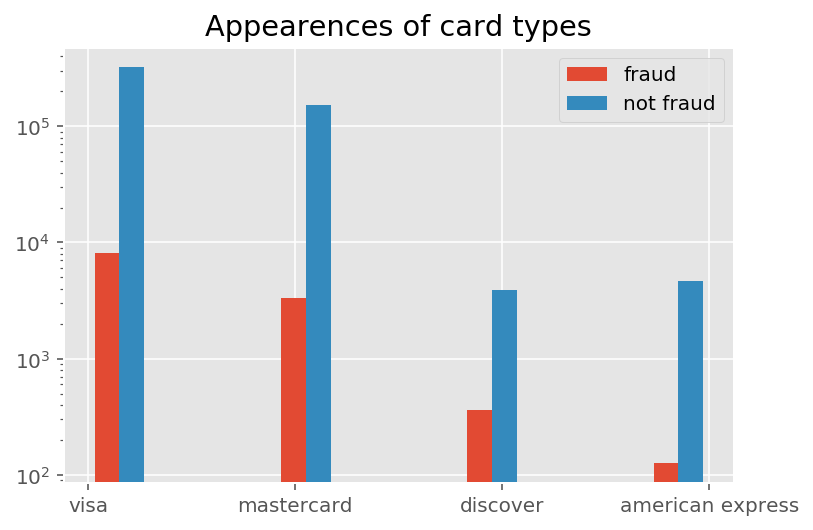

In [246]:
plt.title('Appearences of card types')

plt.hist(
    [train[train.isFraud == 1]['card4'], train[train.isFraud == 0]['card4']],
    log=True)
plt.legend(labels=['fraud', 'not fraud'], loc='upper right')

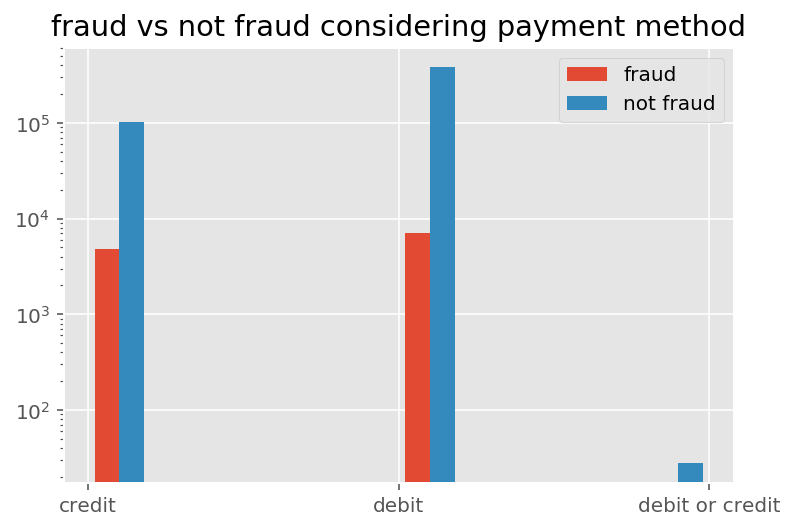

In [99]:
plt.hist(
    [train[train.isFraud == 1]['card6'], train[train.isFraud == 0]['card6']],
    log=True)
plt.legend(labels=['fraud', 'not fraud'], loc='upper right')
plt.title('fraud vs not fraud considering payment method')

In [100]:
card_cols = [x for x in train.columns if 'card' in x]
card_cols.remove('card4')
card_cols = card_cols[:4]

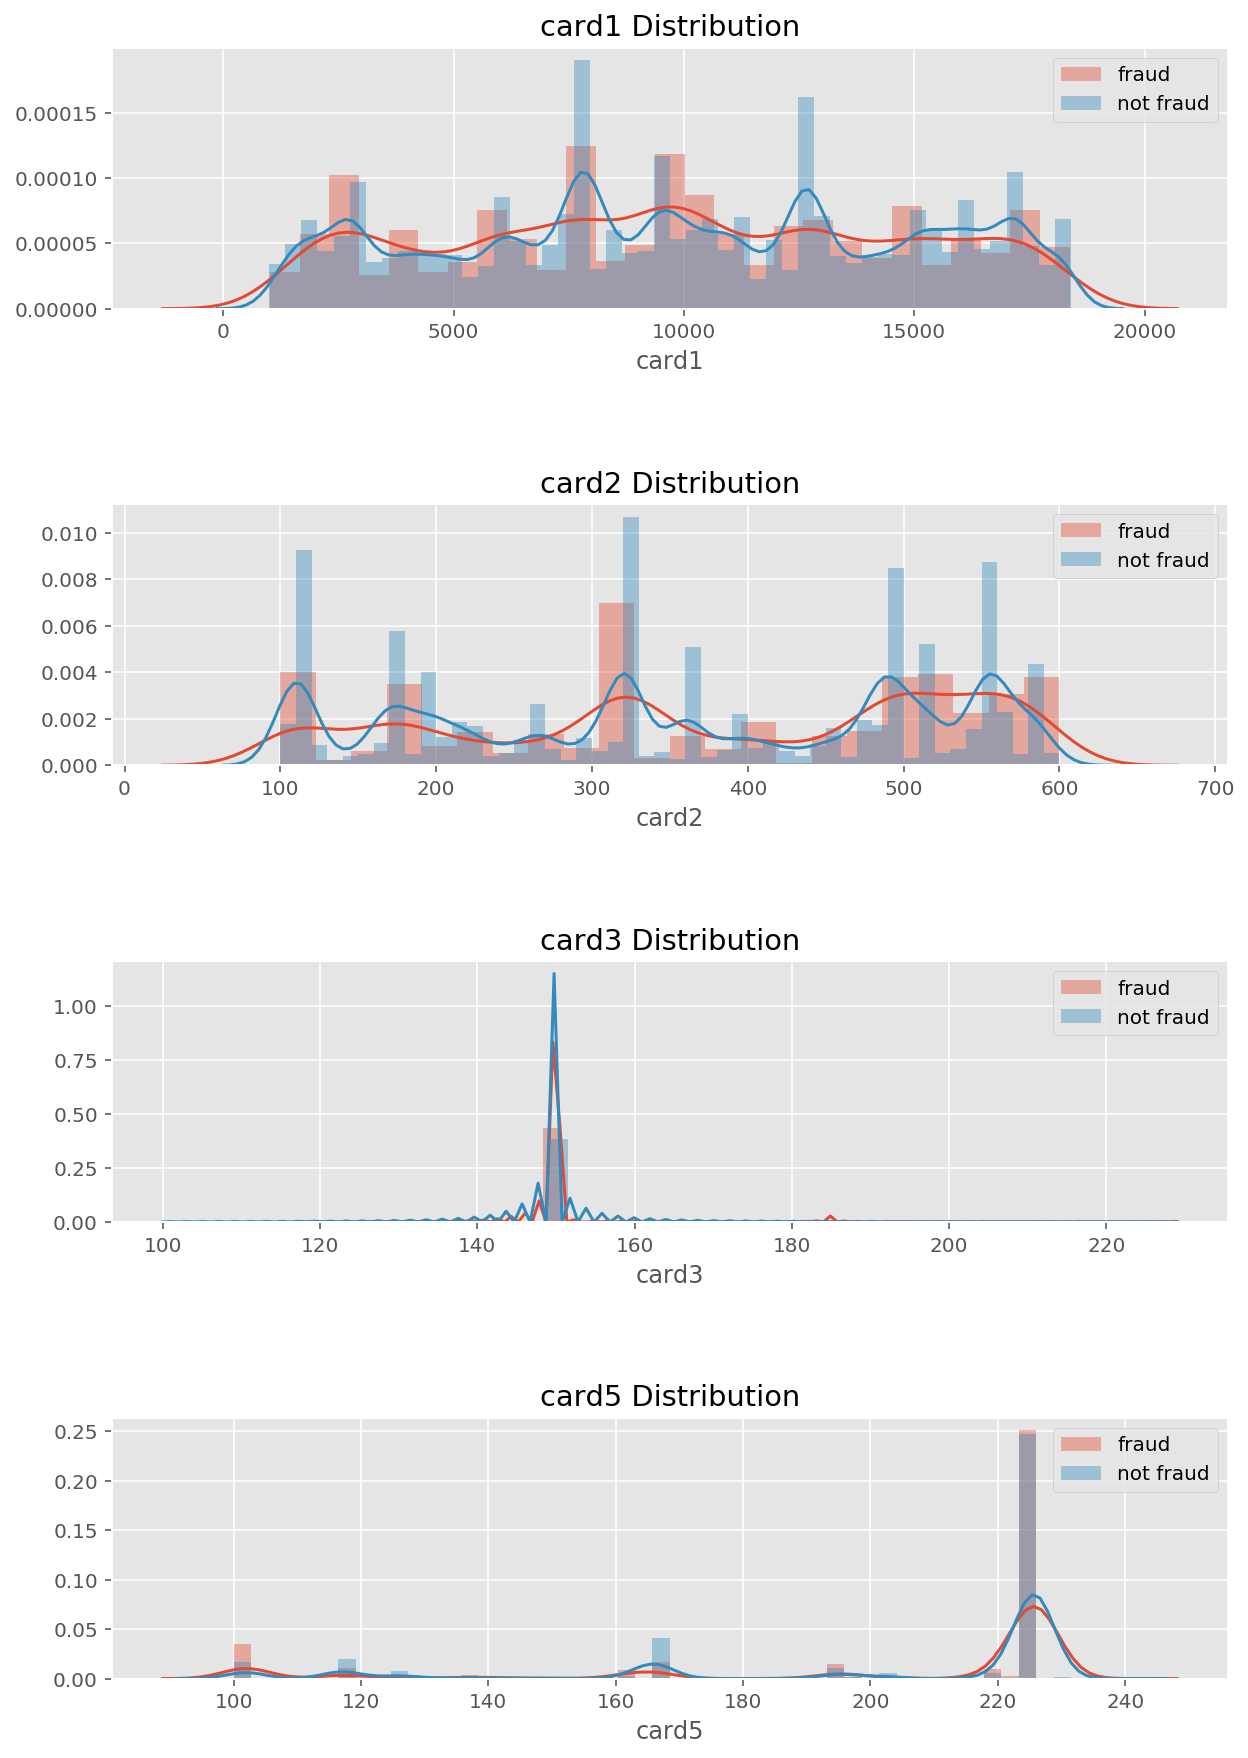

In [102]:
fig, ax = plt.subplots(4, 1, figsize=(10, 15))
fig.subplots_adjust(hspace=0.75)
for ind in range(len(card_cols)):
    sns.distplot(train[train.isFraud == 1][card_cols[ind]], ax=ax[ind])
    sns.distplot(train[train.isFraud == 0][card_cols[ind]], ax=ax[ind])

    ax[ind].legend(labels=['fraud', 'not fraud'], loc='upper right')
    ax[ind].set_title(f'{card_cols[ind]} Distribution')

In [103]:
c_cols = [x for x in train.columns if 'C' in x]
c_cols = c_cols[1:-5]

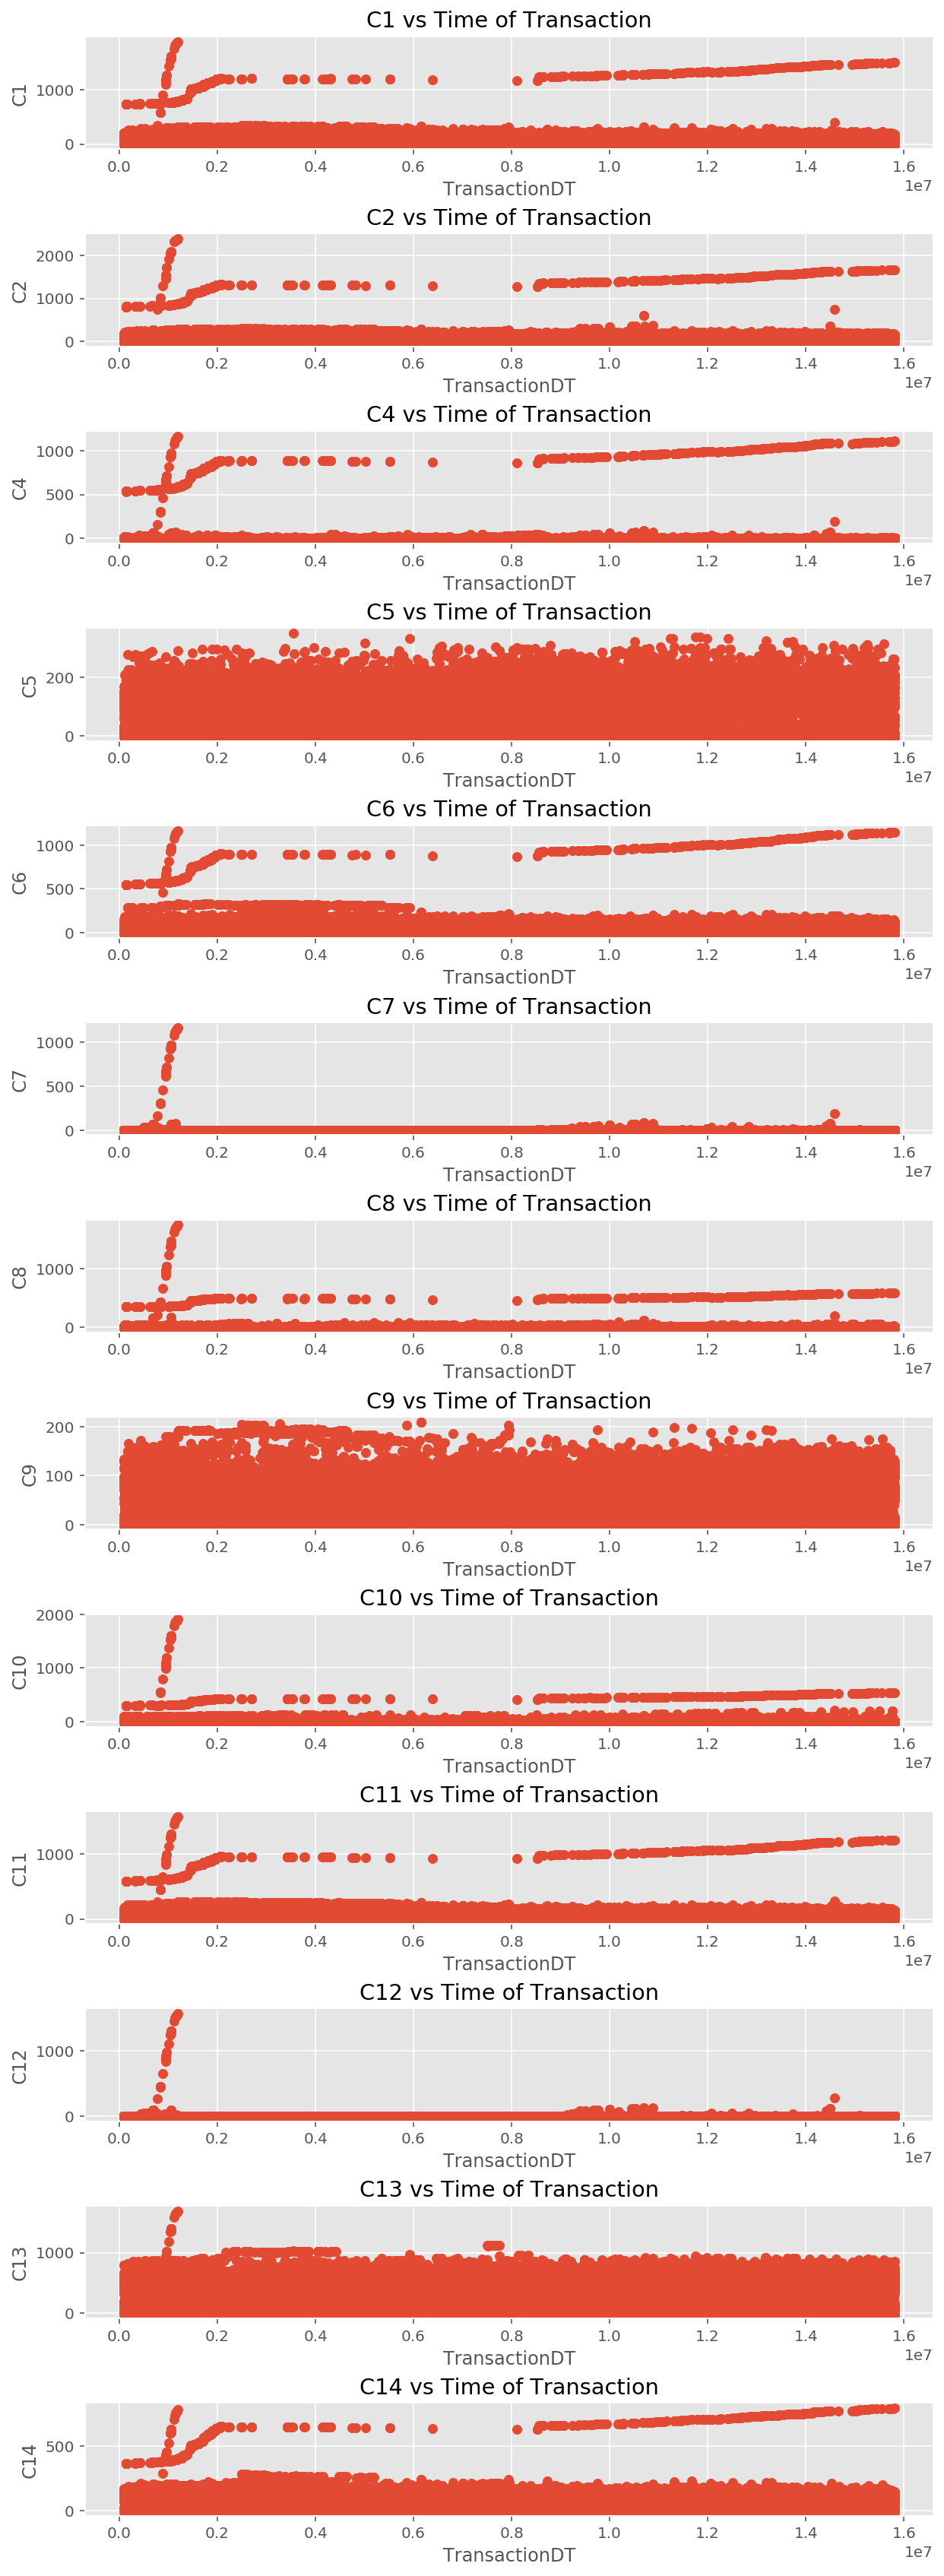

In [104]:
fig, ax = plt.subplots(13, 1, figsize=(10, 30))
fig.subplots_adjust(hspace=0.75)
for ind in range(len(c_cols)):
    ax[ind].scatter(train['TransactionDT'], train[c_cols[ind]])
    ax[ind].set_ylabel(c_cols[ind])
    ax[ind].set_xlabel('TransactionDT')
    ax[ind].set_title(f'{c_cols[ind]} vs Time of Transaction')

This pattern looks quite strange, not entirely sure what to make of it. As the transactions happen over a year period it could be seasonal trends maybe. Either way uncertain. Looked on discussion forums and see equally confused people.

In [105]:
train_label = train.copy()

In [106]:
le = preprocessing.LabelEncoder()
for col in train_label.drop(columns=['isFraud']).columns:
    if train_label[col].dtype == 'object':
        le.fit(list(train_label[col].values))
        train_label[col] = le.transform(list(train_label[col].values))

In [107]:
scaler = StandardScaler()
#need to scale for pca to work
train_label = scaler.fit_transform(train_label)

In [116]:
pca_l = PCA(n_components=300)
pca_label_feat = pca_l.fit_transform(train_label)

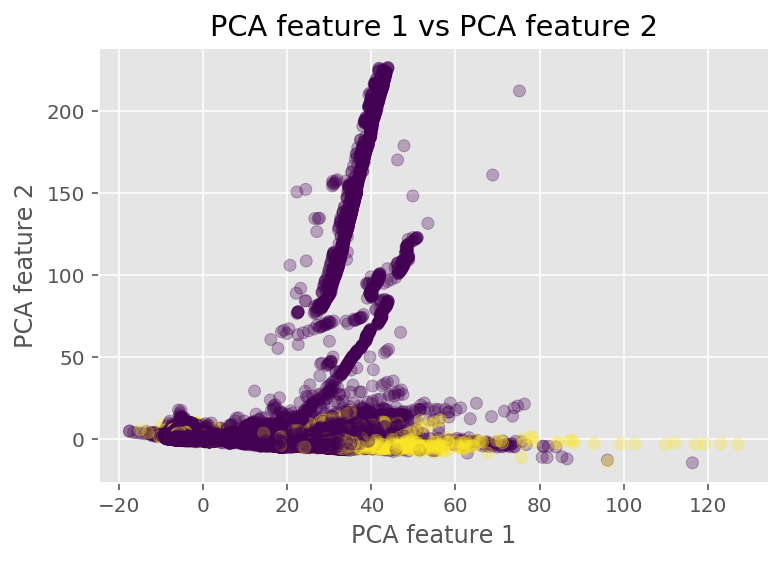

In [118]:
plt.scatter(x=pca_label_feat[:, 0], y=pca_label_feat[:, 1], c=y, alpha=0.3)
plt.xlabel('PCA feature 1')
plt.ylabel('PCA feature 2')
plt.title('PCA feature 1 vs PCA feature 2')

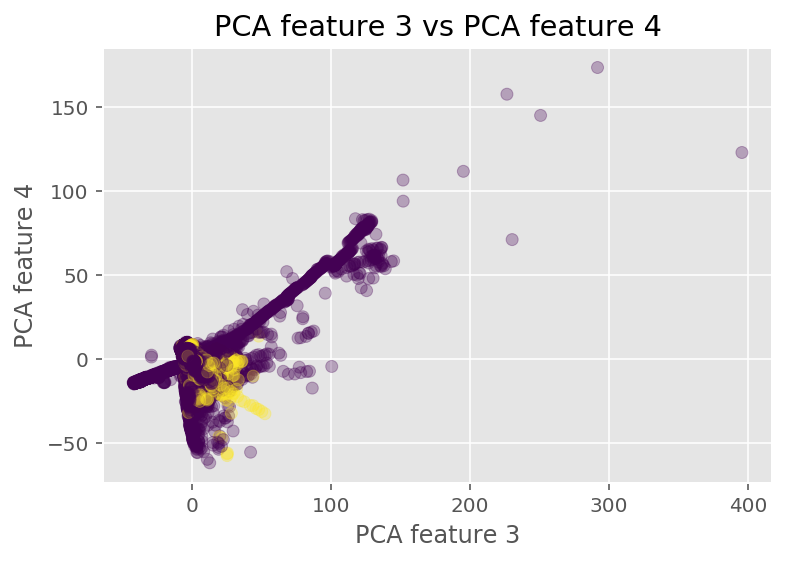

In [119]:
plt.scatter(x=pca_label_feat[:, 2], y=pca_label_feat[:, 3], c=y, alpha=0.3)
plt.xlabel('PCA feature 3')
plt.ylabel('PCA feature 4')
plt.title('PCA feature 3 vs PCA feature 4')

## Modelling

In [121]:
#labeling categorical features
train_label=train.copy()
le = preprocessing.LabelEncoder()
for col in train_label.drop(columns=['isFraud']).columns:
    if train_label[col].dtype=='object':
        le.fit(list(train_label[col].values))
        train_label[col]= le.transform(list(train_label[col].values))

In [122]:
#reducing memory usage
train_label=reduce_mem_usage(train_label)

Memory usage of dataframe is 1615.51 MB
Memory usage after optimization is: 434.94 MB
Decreased by 73.1%


In [149]:
#splitting out x and y
X=train_label.copy()
X.sort_values(by='TransactionDT',inplace=True)
X.drop(columns=['TransactionID','TransactionDT'],inplace=True)
y=X.pop('isFraud')

In [150]:
#scaling X
X=scaler.fit_transform(X)

#### Difference between lightgbm/gradient boost and ada boost

In [219]:
params = {'num_leaves': 492,
          'min_child_weight': 0.0345,
          'feature_fraction': 0.380,
          'bagging_fraction': 0.418,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.007,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.39,
          'reg_lambda': 0.65,
          'random_state': 1,
         }



In [221]:
num_folds = 5
folds = KFold(n_splits=NFOLDS)
splits = folds.split(X, y)
#initialising array to store predictions
y_preds_oof = np.zeros(X.shape[0])
score = 0
#going to make dict of features for each fold
feature_importances={}
  
for fold_n, (train_index, test_index) in enumerate(splits):
    #the test split is the oof split
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    #creating dataset for lgb to work
    dtrain = lgb.Dataset(X_train, label=y_train)
    dtest = lgb.Dataset(X_test, label=y_test)
    
    #initialising light gbm classifer
    clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dtest], verbose_eval=200, early_stopping_rounds=500)
    
    #getting feature importance for each fold
    feature_importances[fold_n]=clf.feature_importance()
    #getting oof predictions
    y_pred_test = clf.predict(X_test)
    y_preds_oof[test_index] = y_pred_test
    #getting roc_auc score
    print(f"Fold {fold_n + 1} | ROC AUC score: {roc_auc_score(y_test, y_pred_test)}")
    #storing the score
    score += roc_auc_score(y_test, y_pred_test) / num_folds
    
    #deleting train and test as dont need anymore
    del X_train, X_test, y_train, y_test
    
    


Training until validation scores don't improve for 500 rounds
[200]	training's auc: 0.961117	valid_1's auc: 0.875096
[400]	training's auc: 0.984916	valid_1's auc: 0.889311
[600]	training's auc: 0.994674	valid_1's auc: 0.898006
[800]	training's auc: 0.99829	valid_1's auc: 0.901984
[1000]	training's auc: 0.999505	valid_1's auc: 0.903953
[1200]	training's auc: 0.999856	valid_1's auc: 0.904275
[1400]	training's auc: 0.99996	valid_1's auc: 0.904623
[1600]	training's auc: 0.999988	valid_1's auc: 0.90478
[1800]	training's auc: 0.999997	valid_1's auc: 0.904891
[2000]	training's auc: 0.999999	valid_1's auc: 0.905101
[2200]	training's auc: 1	valid_1's auc: 0.905332
[2400]	training's auc: 1	valid_1's auc: 0.905393
[2600]	training's auc: 1	valid_1's auc: 0.905376
[2800]	training's auc: 1	valid_1's auc: 0.905401
[3000]	training's auc: 1	valid_1's auc: 0.905529
[3200]	training's auc: 1	valid_1's auc: 0.905425
[3400]	training's auc: 1	valid_1's auc: 0.905379
Early stopping, best iteration is:
[2948]	

In [251]:
print(f"Mean AUC : {score}")
print(f"Out of folds AUC : {roc_auc_score(y, y_oof)}")

Mean AUC : 0.9200340441470185
Out of folds AUC : 0.918580137554748


In [223]:
#storing feature importances and getting the average
light_feature_importances=pd.DataFrame(feature_importances)
light_feature_importances['avg']=light_feature_importances.apply(lambda x: x.mean(),axis=1)

In [224]:

cols=train_label.columns
cols=list(cols)
for col in ['TransactionID','TransactionDT','isFraud']:
    cols.remove(col)

In [225]:
light_feature_importances['features']=cols
light_feature_importances.sort_values(by='avg',ascending=False).head(10)

,0,1,2,3,4,avg,features
394,56851,26564,19750,27704,26580,31489.8,id_02_mean_card1
3,46078,21261,15717,22784,21623,25492.6,card2
8,44916,19774,14582,21732,20600,24320.8,addr1
406,48731,19014,12829,21138,18664,24075.2,TransactionAmt_std_card1
405,44797,16820,11426,18643,17573,21851.8,TransactionAmt_mean_card1
395,39618,17443,12767,18835,18196,21371.8,id_02_mean_addr1
396,38997,16714,12077,18102,17618,20701.6,id_02_std_addr1
2,36334,16799,12182,18476,17349,20228.0,card1
412,39576,16645,10728,17063,16537,20109.8,card1_TransactionAmt_mean
413,39121,15519,11140,16609,15366,19551.0,card1_TransactionAmt_std


In [226]:
avg_light_feat=light_feature_importances[['avg','features']].sort_values(by='avg',ascending=False)[:50]

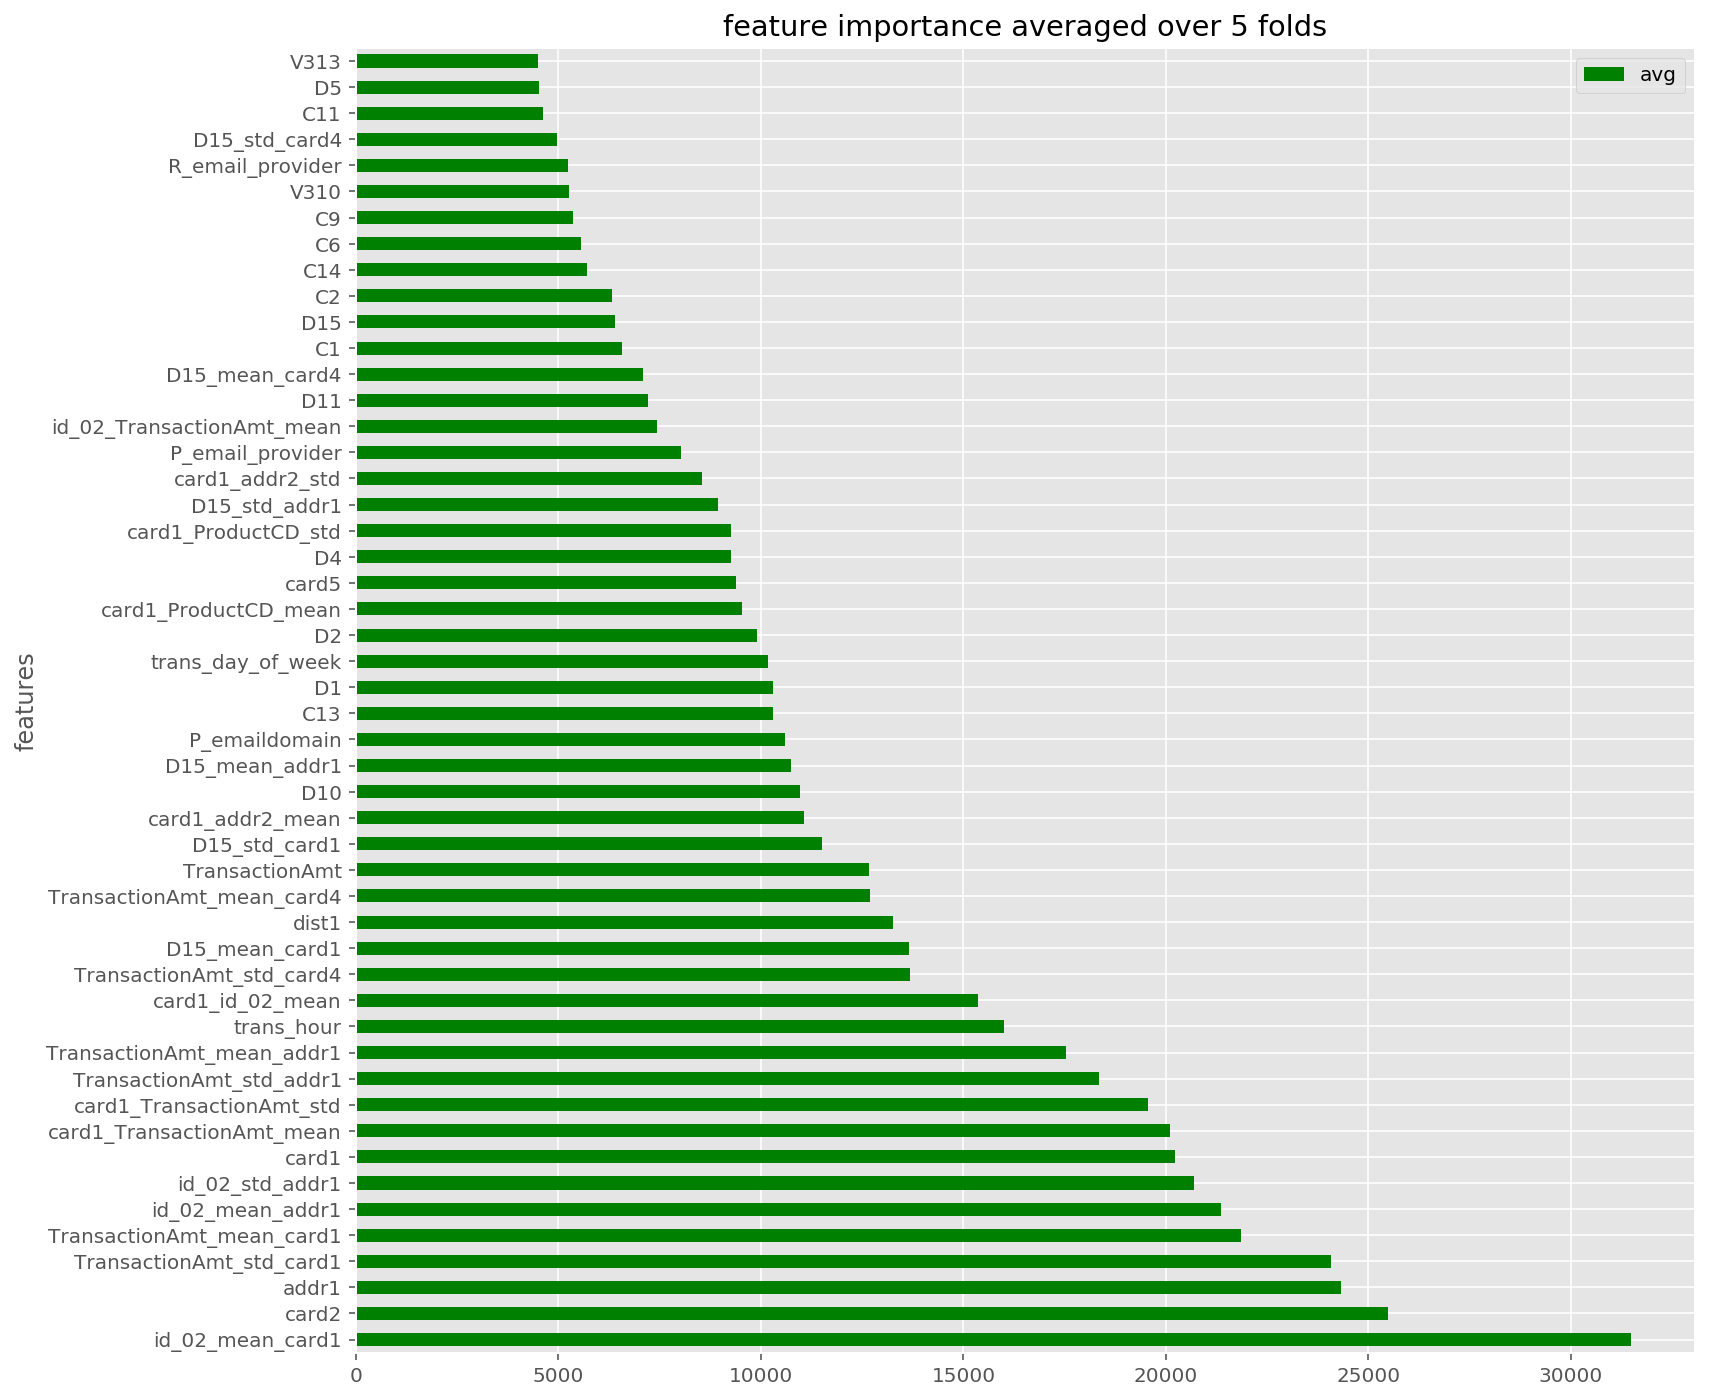

In [227]:
avg_light_feat.set_index(keys=avg_light_feat.features).plot(kind='barh',figsize=(12,12),colormap='ocean',title='feature importance averaged over 5 folds');

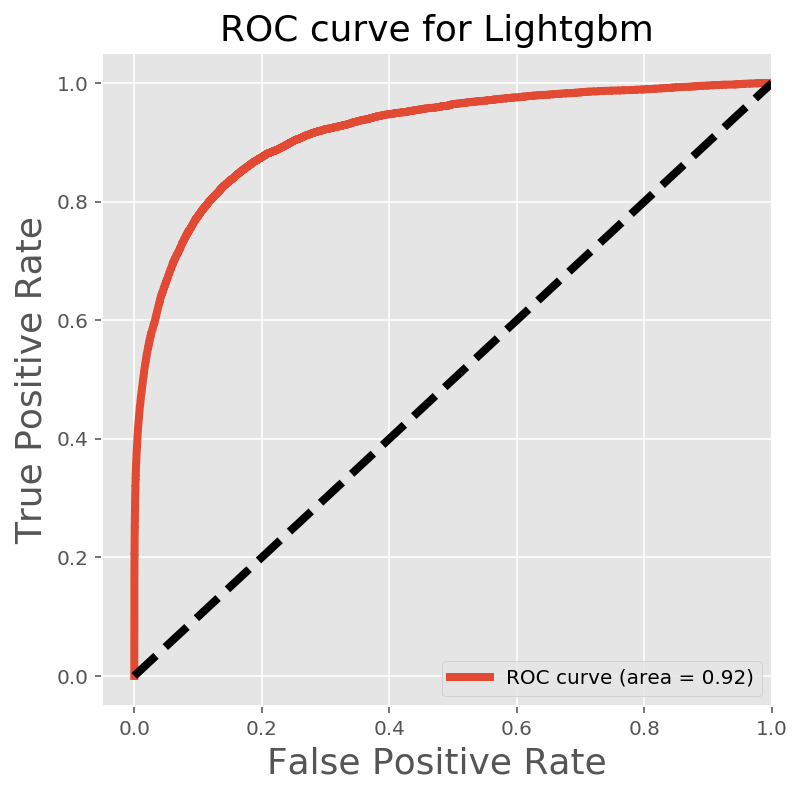

In [231]:
#plotting roc curve
fpr, tpr, threshold = roc_curve(y,
                                y_preds_oof)
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for class 1
plt.figure(figsize=[6, 6])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC curve for Lightgbm', fontsize=18)
plt.legend(loc="lower right")
plt.show()